<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/16march_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# multi-class u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [3]:
pip install matplotlib

In [4]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.4 MB/s eta 0:00:00


In [5]:
import rasterio
from sklearn.model_selection import train_test_split
import shutil
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

# Prepare paths of input images and target segmentation masks (for Planet data)

In [6]:
input_img_paths = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/*.tif"))
target_img_paths = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_labels/*.tif"))

size_x = 384
size_y = 384
img_size = (size_x, size_y)
num_classes = 13
batch_size = 1


# input_img_paths = sorted(glob.glob(input_dir))

# target_img_paths = sorted(glob.glob(target_dir))

print("Number of samples:", len(input_img_paths))
print("Number of labels:", len(target_img_paths))



Number of samples: 2825
Number of labels: 2825


In [ ]:
# input_img_paths

# What does one input image and corresponding segmetation mask look like?

(384, 384)


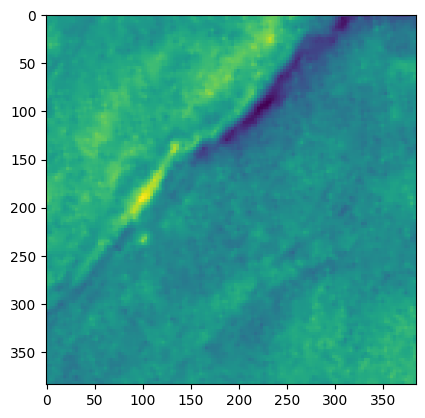

In [9]:
dataset = gdal.Open(input_img_paths[225])
band = dataset.GetRasterBand(8)
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

(384, 384)


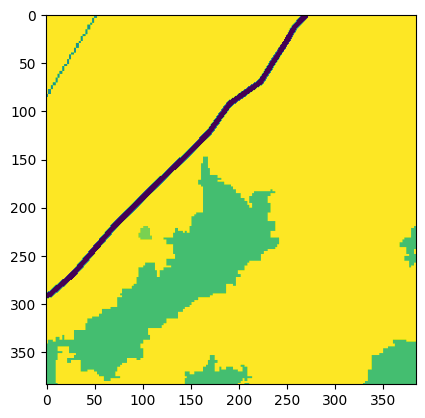

In [10]:
datasetLabel = gdal.Open(target_img_paths[225])
band = datasetLabel.GetRasterBand(1)
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

In [ ]:
# from tensorflow import keras
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img


# from tensorflow import keras
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img

# class LandCover(keras.utils.Sequence):
#     """
#     A custom Sequence class to serve as a data generator for feeding training data
#     to the Keras model in batches.
#     """

#     def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
#         """
#         Class constructor, which initializes the data generator with the data it needs.

#         Parameters:
#         - batch_size: the number of samples per batch to load.
#         - img_size: tuple of integers (height, width), the dimensions to which input images will be resized.
#         - input_img_paths: list of file paths to the input images.
#         - target_img_paths: list of file paths to the target images (labels).
#         """
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.input_img_paths = input_img_paths
#         self.target_img_paths = target_img_paths

#     def __len__(self):
#         """
#         Computes the number of batches needed to go through the entire dataset.
#         """
#         return len(self.target_img_paths) // self.batch_size

#     def __getitem__(self, idx):
#         """
#         Retrieves a batch of data by its index, allowing the model to access a subset of the data.

#         Parameters:
#         - idx: the index of the batch.

#         Returns:
#         - A tuple (x, y), where x is the batch of input images and y is the batch of target images (labels).
#         """
#         # Calculate the starting index of the batch
#         i = idx * self.batch_size
#         # Get the paths for the current batch
#         batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
#         batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

#         # Initialize the arrays for the input images with zeros
#         x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
#         for j, path in enumerate(batch_input_img_paths):
#             img = load_img(path, target_size=self.img_size)
#             x[j] = img  # Load and store the image

#         # # Initialize the arrays for the target images (labels) with zeros
#         # y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
#         # for j, path in enumerate(batch_target_img_paths):
#         #     img = load_img(path, target_size=self.img_size, color_mode="grayscale")
#         #     y[j] = np.expand_dims(img, 2)  # Load, add a channel dimension, and store the image

#         #     # Adjust labels to be zero-indexed
#         #     y[j] -= 1  # Subtract one to make labels 0, 1, 2, etc.

#         return x, y


In [ ]:
# import rasterio
# import numpy as np
# from tensorflow import keras
# import keras
# import numpy as np
# from tensorflow import data as tf_data
# from tensorflow import image as tf_image
# from tensorflow import io as tf_io

# class LandCover(keras.utils.Sequence):
#     """Helper to iterate over the data (as Numpy arrays)."""

#     def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
#         self.batch_size = batch_size
#         self.img_size = img_size  # img_size is expected to be a tuple (height, width)
#         self.input_img_paths = input_img_paths
#         self.target_img_paths = target_img_paths

#     def __len__(self):
#         return len(self.target_img_paths) // self.batch_size

#     def __getitem__(self, idx):
#         """Returns tuple (input, target) correspond to batch #idx."""
#         i = idx * self.batch_size
#         batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
#         batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
#         x = np.zeros((self.batch_size, *self.img_size, 13), dtype="float32")  # Change 3 to 13 for 13-band images
#         y = np.zeros((self.batch_size, *self.img_size, 1), dtype="uint8")  # No change needed here if labels are single-channel

#         for j, path in enumerate(batch_input_img_paths):
#             with rasterio.open(path) as dataset:
#                 img = dataset.read().astype('float32')
#                 img = np.transpose(img, (1, 2, 0))  # Rearrange the dimensions to (height, width, bands)
#                 # Optionally resize img here if necessary
#                 x[j] = img

#         for j, path in enumerate(batch_target_img_paths):
#             with rasterio.open(path) as dataset:
#                 img = dataset.read(1).astype('uint8')
#                 # Optionally resize img here if necessary
#                 img = np.expand_dims(img, -1)  # Add a channel dimension so the shape becomes (height, width, 1)
#                 y[j] = img - 1  # Assuming labels are from 1 to N, subtract 1 to get 0 to N-1

#         return x, y


# (Direct from oxford_pets_image_segmentation) Prepare dataset to load and vectorize batches of data

In [11]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [ ]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # issue if it's 13. when I put it back to 3 i didnt get the invadid error.

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 13, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 13, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# num_classes = 13

# Build model
model = get_model(img_size, num_classes)
model.summary()

# Set aside a validation split

In [32]:
import random

# Split our img paths into a training and a validation set
val_samples = 282 #  10% of data

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=282,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)


# # Instantiate data Sequences for each split
# train_gen = LandCover(
#     batch_size, img_size, train_input_img_paths, train_target_img_paths
# )
# # print(train_gen[0][1][0])
# val_gen = LandCover(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# Train the model

In [33]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]



In [37]:
# # Train the model, doing validation at the end of each epoch.
# epochs = 5
# model.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=valid_dataset,
#     callbacks=callbacks,
#     verbose=2,
# )

In [ ]:
# model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

## other

In [ ]:

# # List of files to copy
# # files_to_copy = ['path/to/source/file1.txt', 'path/to/source/file2.jpg', 'path/to/source/file3.pdf']
# # Destination directory
# destination = '/content/train_images'

# # Ensure the destination directory exists
# os.makedirs(destination, exist_ok=True)

# # Loop through the list and copy each file
# for file in train_images_paths:
#     # Define the full destination path for the current file
#     dest_file = os.path.join(destination, os.path.basename(file))
#     # Copy the file
#     shutil.copy(file, dest_file)
#     print(f'Copied {file} to {dest_file}')



# # Destination directory
# destination = '/content/train_labels'

# # Ensure the destination directory exists
# os.makedirs(destination, exist_ok=True)

# # Loop through the list and copy each file
# for file in train_labels_paths:
#     # Define the full destination path for the current file
#     dest_file = os.path.join(destination, os.path.basename(file))
#     # Copy the file
#     shutil.copy(file, dest_file)
#     print(f'Copied {file} to {dest_file}')


In [ ]:
# # Ensure the lists are sorted so that images and labels correspond to each other
# planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_labels/*.tif"))
# planet_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/*.tif"))

# # Split the file paths into training and testing sets (80% train, 20% test)
# train_images_paths, test_images_paths, train_labels_paths, test_labels_paths = train_test_split(
#     planet_images, planet_labels, test_size=0.2, random_state=42)